In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [3]:
numerical_features = df.select_dtypes(include="number").columns.tolist()
categorical_features = df.select_dtypes(include="object").columns.tolist()

df[numerical_features] = df[numerical_features].fillna(0)
df[categorical_features] = df[categorical_features].fillna("NA")

In [4]:
# Splitting the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

features = categorical_features + numerical_features
features.remove("converted")

# Training set
X_train = df_train[features].reset_index(drop=True)
y_train = df_train["converted"].reset_index(drop=True)

# Validation set
X_val = df_val[features].reset_index(drop=True)
y_val = df_val["converted"].reset_index(drop=True)

# Test set
X_test = df_test[features].reset_index(drop=True)
y_test = df_test["converted"].reset_index(drop=True)

In [5]:
# Question 1

auc_scores = {}

for col in X_train.select_dtypes(include='number').columns:
    scores = X_train[col]
    auc = roc_auc_score(y_train, scores)

    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)
    
    auc_scores[col] = auc

pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC']).sort_values(by='AUC', ascending=False)

,AUC
number_of_courses_viewed,0.763568
interaction_count,0.738270
lead_score,0.614499
annual_income,0.551958


In [6]:
# Question 2

dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient='records')
X_train_Q2 = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient='records')
X_val_Q2 = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_Q2, y_train)

y_pred = model.predict_proba(X_val_Q2)[:, 1]

auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

0.817

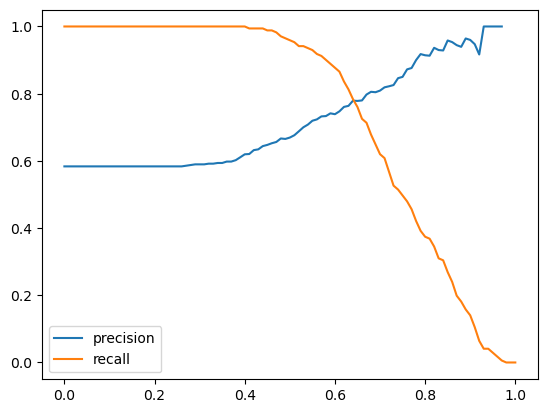

In [7]:
# Question 3

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

In [9]:
df_scores["pr_diff"] = np.abs(df_scores["precision"] - df_scores["recall"])
df_scores[(df_scores["precision"] != 0) & (df_scores["recall"] != 0)].sort_values("pr_diff").iloc[0]["threshold"]

np.float64(0.64)

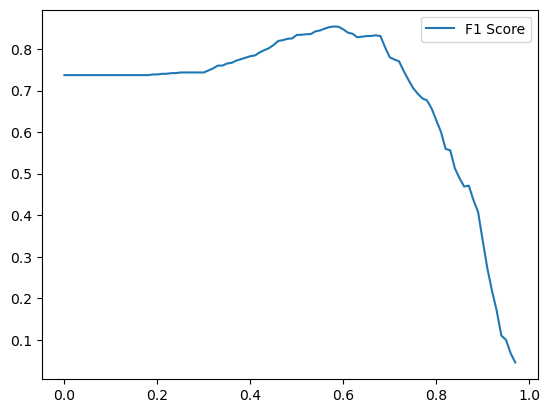

In [8]:
# Question 4

df_scores["f1"] = (2 * df_scores.precision * df_scores.recall)/(df_scores.precision + df_scores.recall)
plt.plot(df_scores.threshold, df_scores['f1'], label='F1 Score')
plt.legend()

In [9]:
df_scores[df_scores.f1 == df_scores.f1.max()]

,threshold,tp,fp,fn,tn,precision,recall,f1
58,0.58,161,45,10,77,0.781553,0.94152,0.854111


In [10]:
# Question 5

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_features + numerical_features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical_features + numerical_features].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.876 +- 0.032


In [11]:
# Question 6

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_features + numerical_features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical_features + numerical_features].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_score = round(np.mean(scores), 3)
    std_score = round(np.std(scores), 3)

    results.append((C, mean_score, std_score))
    print(f"C={C}  Mean AUC={mean_score}  Std={std_score}")

C=1e-06  Mean AUC=0.561  Std=0.024
C=0.001  Mean AUC=0.926  Std=0.018
C=1  Mean AUC=0.876  Std=0.032
